## Canine GWAS Target Variant QC

Steps:
    
- Load the list of samples for which to run variant QC on
- Run HWE filtering for that set of samples
- Subset the original target dataset to only variants passing all filters
- **Output**: A version of the original target dataset with fewer variants

In [1]:
import os
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os.path as osp
from IPython.display import Image, display
%run {os.environ['NB_DIR']}/nb.py
%run paths.py
%run common.py
gab.register_timeop_magic(get_ipython(), 'hail')
hl.init()

Running on Apache Spark version 2.4.4
SparkUI available at http://d40dbc6dadcd:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.32-a5876a0a2853
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/organism/canine/hail-20200216-2228-0.2.32-a5876a0a2853.log


## Load Target Dataset and QC Samples

In [2]:
%%capture
hl.ReferenceGenome(**load_reference_genome(REF_GENOME_FILE))

In [4]:
mt = hl.import_plink(
    *plink_files(ORGANISM_CANINE_TGT_DIR, PLINK_FILE_TGT),
    skip_invalid_loci=False,
    reference_genome='canine'
)
mt.count()

2020-02-16 22:30:45 Hail: INFO: Found 4342 samples in fam file.
2020-02-16 22:30:45 Hail: INFO: Found 160727 variants in bim file.
2020-02-16 22:30:45 Hail: INFO: Coerced sorted dataset


(160727, 4342)

In [10]:
ht_qc_samp = hl.read_table(osp.join(WORK_DIR, TGT_QC_04_FILE + '.ht')).key_by('s')
ht_qc_samp.count()

156

In [15]:
mt_qc_samp = mt.filter_cols(hl.is_defined(ht_qc_samp[mt.col_key]))
mt_qc_samp = hl.variant_qc(mt_qc_samp)
assert mt_qc_samp.count()[1] == ht_qc_samp.count()
mt_qc_samp.count()

2020-02-16 22:41:02 Hail: INFO: Coerced sorted dataset
2020-02-16 22:41:02 Hail: INFO: Coerced sorted dataset
2020-02-16 22:41:03 Hail: INFO: Coerced sorted dataset
2020-02-16 22:41:04 Hail: INFO: Coerced sorted dataset


(160727, 156)

## QC

In [122]:
def get_qc_stat_df(mt):
    df = mt.transmute_rows(
        maf=mt.variant_qc.AF[1], 
        hwep=mt.variant_qc.p_value_hwe,
        cr=mt.variant_qc.call_rate
    ).rows().to_pandas()
    return (
        df
        .assign(alleles=lambda df: df['alleles'].apply(''.join))
        .set_index(['locus.contig', 'locus.position', 'alleles'])[['maf', 'hwep', 'cr']]
        .rename_axis('metric', axis='columns')
        .stack().rename('value').reset_index()
    )
df = get_qc_stat_df(mt_qc_samp)
df.head()

2020-02-17 11:38:01 Hail: INFO: Coerced sorted dataset


,locus.contig,locus.position,alleles,metric,value
0,1,212740,GA,maf,0.185897
1,1,212740,GA,hwep,0.046523
2,1,212740,GA,cr,1.000000
3,1,249580,AG,maf,0.000000
4,1,249580,AG,hwep,0.500000


In [123]:
threshold_hwep = 10e-12 # UKBB threshold is 10e-12 for within-batch variant QC
threshold_call_rate = .96 # UKBB does NOT do call rate thresholding in this stage but we will

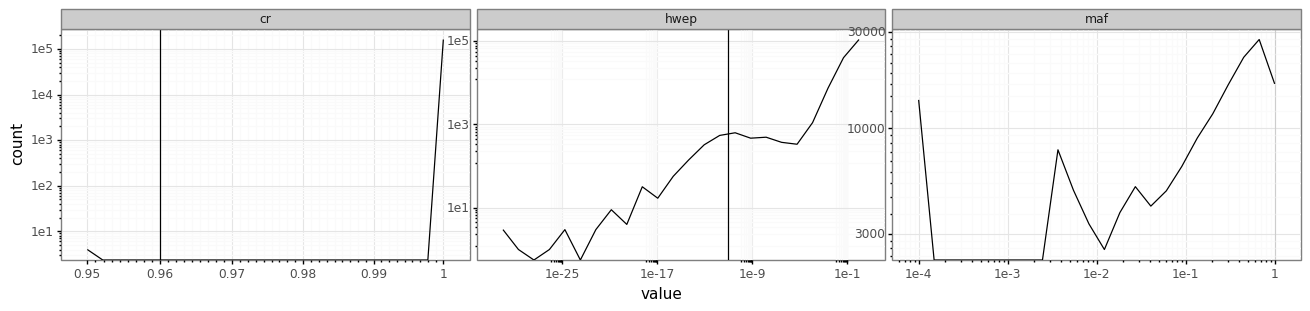

<ggplot: (8779342822673)>

In [124]:
# Find a way to do histogram visualizations for multiple traces (and thresholds) that doesn't involve 
# collecting vectors of size equal to num variants

def clip_value(r):
    if r['metric'] == 'maf':
        return max(r['value'], 1e-4)
    if r['metric'] == 'hwep':
        return max(r['value'], 1e-30)
    if r['metric'] == 'cr':
        return max(r['value'], .95)
    raise NotImplementedError(f"Metric {r['metric']} not supported")
    
p = (
    pn.ggplot(
        df
            .assign(threshold=lambda df: df['metric'].map({
                'maf': 1, 'cr': threshold_call_rate, 'hwep': threshold_hwep}))
            .assign(alpha=lambda df: df['metric'].map({'maf': 0, 'cr': 1, 'hwep': 1}))
            .assign(value=lambda df: df.apply(clip_value, axis=1)),
        pn.aes(x='value') 
    ) + 
    pn.geom_freqpoly(bins=24) + 
    pn.scale_alpha_continuous(guide=False) + 
    pn.geom_vline(mapping=pn.aes(xintercept='threshold', alpha='alpha')) + 
    pn.scale_y_log10() + 
    pn.scale_x_log10() +
    pn.facet_wrap(' ~ metric', scales='free') + 
    pn.theme_bw() + 
    pn.theme(figure_size=(16, 3))
)
with np.errstate(divide='ignore'):
    display(p)

Show how many of the variants have an MAF of zero or one in the target sample:

In [119]:
df[df['metric'] == 'maf'].assign(maf_gt_zero=lambda df: df['value'] > 0)['maf_gt_zero'].value_counts()

True     146896
False     13831
Name: maf_gt_zero, dtype: int64

In [125]:
df[df['metric'] == 'maf'].assign(maf_lt_one=lambda df: df['value'] < 1)['maf_lt_one'].value_counts()

True     160660
False        67
Name: maf_lt_one, dtype: int64

#### Investigate MAF

For comparison, the randomly drawn sample subsets below will demonstrate how MAF changes as a function of sample size.  This comparison is helpful for understanding why the MAF in our homogeneous subset above is 0 for so many variants (about 14k of 147k).  

The random subsets will be much more heterogeneous than our target subset and should show far fewer variants with MAF 0, even for small numbers of samples.

This will also help us ensure that the array used to genotype this sample does not also include many probes irrelevant for the samples measured.  This would be evident if the MAF is 0 for a large number of variants even across all samples in the dataset.

In [126]:
# Randomly selected sample subsets of varying sizes (and compute MAF for them)
def sample_mafs():
    df = []
    for n in [10, 25, 50, 100, mt_qc_samp.count()[1], 200, 300, mt.count()[1]]:
        mts = hl.variant_qc(mt.sample_cols(p=float(n)/mt.count()[1], seed=1))
        df.append(mts.select_rows(maf=mts.variant_qc.AF[1]).rows().key_by().to_pandas().assign(n=n))
    return pd.concat(df)

dfs = sample_mafs()
dfs.head()

2020-02-17 11:50:21 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:21 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:22 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:22 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:23 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:33 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:33 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:43 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:43 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:53 Hail: INFO: Coerced sorted dataset
2020-02-17 11:50:54 Hail: INFO: Coerced sorted dataset
2020-02-17 11:51:04 Hail: INFO: Coerced sorted dataset
2020-02-17 11:51:04 Hail: INFO: Coerced sorted dataset
2020-02-17 11:51:13 Hail: INFO: Coerced sorted dataset
2020-02-17 11:51:14 Hail: INFO: Coerced sorted dataset
2020-02-17 11:51:24 Hail: INFO: Coerced sorted dataset
2020-02-17 11:51:25 Hail: INFO: Coerced sorted dataset
2020-02-17 11:51:34 Hail: INFO: Coerced sorted dataset
2020-02-17

,locus.contig,locus.position,alleles,maf,n
0,1,212740,"[G, A]",0.041667,10
1,1,249580,"[A, G]",0.250000,10
2,1,273487,"[G, A]",0.083333,10
3,1,307563,"[C, A]",0.250000,10
4,1,320055,"[A, G]",0.250000,10


In [127]:
# Show MAF 0 count by sample size
dfs\
    .assign(maf_gt_zero=lambda df: df['maf'] > 0)\
    .groupby('n')['maf_gt_zero'].value_counts()\
    .unstack().fillna(0).astype(int)

maf_gt_zero,False,True
n,,
10,11351,149376
25,4233,156494
50,797,159930
100,151,160576
156,52,160675
200,17,160710
300,4,160723
4342,0,160727


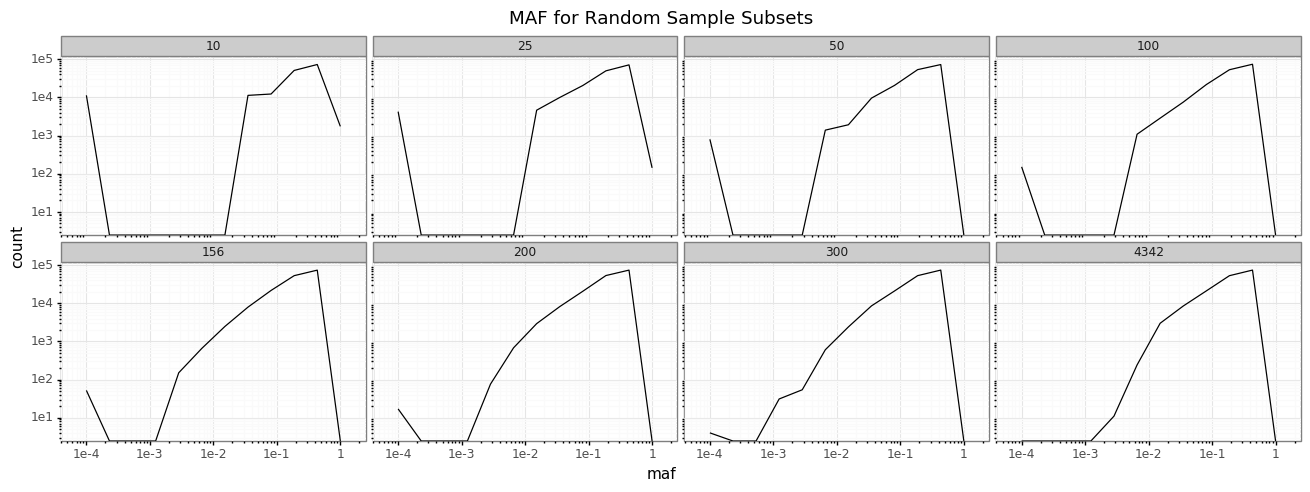

<ggplot: (8779348980125)>

In [128]:
p = (
    pn.ggplot(dfs.assign(maf=lambda df: df['maf'].clip(1e-4, 1)), pn.aes(x='maf')) + 
    pn.geom_freqpoly(bins=12) + 
    pn.facet_wrap('~n', ncol=4) + 
    pn.scale_x_log10() + 
    pn.scale_y_log10() + 
    pn.theme_bw() + 
    pn.theme(figure_size=(16, 5)) + 
    pn.ggtitle('MAF for Random Sample Subsets')
)
with np.errstate(divide='ignore'):
    display(p)

Our homogeneous subset has an MAF of 0 for about 13k variants and we can see immediately above that a similar distribution is seen only with a very small subset of 10 random samples.  We also see here that the number of variants with MAF of 0 approaches 0 as the sample size grows, and essentially equals 0 for the subset that includes all samples (i.e. the last one on the bottom right).  This is a good indication that our homogeneous subset is indeed very homogeneous and that the original dataset does not include many irrelevant probes.  If the latter was true, it could indicate that the "typed" sample (i.e. the one measured with the array) does not match the ancestry of the "ascertainment" sample used to select SNPs for the array in the first place.  This would invalidate many population genetic statistics, including MAF ([Nielson 2004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3525085/)), and though it is not likely in a published dataset like this it is still worth checking.

## Export

In [129]:
mt_qc_filtered = mt_qc_samp.filter_rows(
    (mt_qc_samp.variant_qc.p_value_hwe >= threshold_hwep) & 
    (mt_qc_samp.variant_qc.call_rate >= threshold_call_rate)
)
mt_qc = mt.filter_rows(hl.is_defined(mt_qc_filtered.rows()[mt.row_key]))
# Ensure that number of variants in result equals number of passing variants in target sample dataset
mt_qc_hwe_ct, mt_qc_ct = mt_qc_filtered.count(), mt_qc.count()
assert mt_qc_hwe_ct[0] == mt_qc_ct[0]
mt_qc_ct

2020-02-17 12:08:08 Hail: INFO: Coerced sorted dataset
2020-02-17 12:08:17 Hail: INFO: Coerced sorted dataset
2020-02-17 12:08:18 Hail: INFO: Coerced sorted dataset
2020-02-17 12:08:18 Hail: INFO: Coerced sorted dataset


(159562, 4342)

In [130]:
f'Number of variants removed = {mt.count()[0] - mt_qc_ct[0]}'

2020-02-17 12:08:33 Hail: INFO: Coerced sorted dataset


'Number of variants removed = 1165'

In [131]:
path = osp.join(WORK_DIR, TGT_QC_05_FILE + '.mt')
mt_qc.write(path, overwrite=True)
print('Final result written to', path)

2020-02-17 12:08:36 Hail: INFO: Coerced sorted dataset
2020-02-17 12:08:36 Hail: INFO: Coerced sorted dataset


Final result written to /home/eczech/data/gwas/tmp/canine/mt_tgt_qc_05.mt


2020-02-17 12:09:37 Hail: INFO: wrote matrix table with 159562 rows and 4342 columns in 6 partitions to /home/eczech/data/gwas/tmp/canine/mt_tgt_qc_05.mt
